## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
import pandas as pd
os.chdir('..')
import virl
from matplotlib import pyplot as plt
from collections import deque, namedtuple
from operator import attrgetter
import random

from IPython import display

In [2]:
# Keras and backend for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

from tensorflow import where as tf_where

## Neural Network Class

In [3]:
class NNFunctionApproximatorJointKeras():
    
    def __init__(self, learning_rate, input_layer_dim, output_layer_dim, nn_config, verbose=False):        
        self.learning_rate = learning_rate 
        self.nn_config = nn_config      # determines the size of the hidden layer (if any)              
        self.input_layer_dim = input_layer_dim     
        self.output_layer_dim = output_layer_dim  
        self.verbose=verbose # Print debug information        
        self.n_layers = len(nn_config)
        self.model = self._build_model()  
                        
    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        """
        Huber loss (for use in Keras), see https://en.wikipedia.org/wiki/Huber_loss
        The huber loss tends to provide more robust learning in RL settings where there are 
        often "outliers" before the functions has converged.
        """
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
        return K.mean(tf_where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning 
        model = Sequential()
        for ilayer in self.nn_config:
            model.add(Dense(ilayer, input_dim=self.input_layer_dim, activation='relu'))        
        model.add(Dense(self.output_layer_dim, activation='linear'))
        model.compile(loss=self._huber_loss, # define a special loss function
                      optimizer=Adam(lr=self.learning_rate, clipnorm=10.)) # specify the optimiser, we clip the gradient of the norm which can make traning more robust
        return model

    def predict(self, s, a=None):              
        if a==None:            
            return self._predict_nn(s)
        else:                        
            return self._predict_nn(s)[a]
        
    def _predict_nn(self,state_hat):                          
        """
        Predict the output of the neural netwwork (note: these can be vectors)
        """                
        x = self.model.predict(state_hat)                                                    
        return x
  
    def update(self, states, td_target):
        self.model.fit(states, td_target, epochs=1, verbose=0) # take one gradient step usign Adam               
        return


## Memory Class

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'new_state', 'reward'))

class ReplayMemory():
    """
    Implement a replay buffer using the deque collection
    """

    def __init__(self, size, batch_size):
        self.capacity = size
        self.memory = deque(maxlen=size)
        self.batch_size = batch_size

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def pop(self):
        return self.memory.pop()

    def sample(self):
        return random.sample(self.memory, self.batch_size)
    
    def can_sample(self):
        return len(self.memory) >= self.batch_size
    
    def extract_samples(self):
        returned_batch_size = int(self.batch_size/2)
        
        transitions = self.sample()
        best_transitions = sorted(transitions, key=attrgetter("reward"), reverse=True)
        transitions = best_transitions[:returned_batch_size]
        batch = Transition(*zip(*transitions))
        train_rewards = np.array(batch.reward)
        train_states = np.array(batch.state)
        train_new_state = np.array(batch.new_state)
        train_actions = np.array(batch.action)
        return train_rewards, train_states, train_new_state, train_actions, returned_batch_size
    
 

## Agent Class

In [5]:
class Agent():
    
    def __init__(self, env, learning_rate=0.001):
        self.env = env
        self.n_actions = env.action_space.n
        self.d_states = env.observation_space.shape[0]
        self.learning_rate = learning_rate
        
    def get_action(self, strategy, policy_network, state):
        action = self.get_random_action()
        exploit = False
        if not self.is_learning():
            action = self.predict_action_from_nn(policy_network, state) # exploit
            exploit = True
        else:
            if not strategy.should_explore():
                action = self.predict_action_from_nn(policy_network, state) # exploit
                exploit = True
        return (action, exploit)
    
    def get_num_actions(self):
        return self.n_actions
    
    def get_num_states(self):
        return self.d_states
    
    def get_random_action(self):
        return np.random.choice(self.get_num_actions())
    
    def predict_action_from_nn(self, policy_network, state):
        action = policy_network.predict(state)[0]
        action = np.argmax(action)
        return action
    
    def preprocess_state(self, state):
        return np.reshape(state, [1, self.get_num_states()])
    
    def is_learning(self):
        return self.learning_rate > 0.0

## Epsilon Strategy Class

In [6]:
class Strategy():
    
    def __init__(self, epsilon, epsilon_decay):
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        
    def episode_complete(self):
        self.epsilon *= self.epsilon_decay
        
    def should_explore(self):
        return np.random.random() < self.epsilon

## Initialise Networks Function

In [7]:
def init_networks(input_layer_dim, output_layer_dim, learning_rate=0.001, nn_config=[24,24]):
    # Init the two networks
    policy_network = NNFunctionApproximatorJointKeras(learning_rate, input_layer_dim, output_layer_dim, nn_config)
    target_network = NNFunctionApproximatorJointKeras(learning_rate, input_layer_dim, output_layer_dim, nn_config)
    target_network.model.set_weights(policy_network.model.get_weights())
    return (policy_network, target_network)

## QLearning Function

In [8]:
def plot(all_rewards, smoothed_rewards):
    plt.figure(2, figsize=(12, 6))
    plt.clf()
    plt.title("Training")
    plt.xlabel("Epsiode")
    plt.ylabel("Total Reward")
    plt.plot(all_rewards, '--', alpha=0.5)
    plt.plot(smoothed_rewards)
    plt.legend(["Rewards", "Rewards (Smoothed)"])
    plt.pause(0.0001)
    display.clear_output(wait=True)
    

def qlearning_nn(agent, policy_network, target_network, num_episodes, window_size, strategy=None, memory=None, ):

    if agent.is_learning() and memory is None:
        print("Agent is learning, function requires memory")
    if agent.is_learning() and strategy is None:
        print("Agent is learning, function requires strategy")
    
    discount_factor = 0.95
    env = agent.env
    
    all_rewards = []
    for episode in range(num_episodes):
        done = False
        rewards = []
        exploits = 0
        
        state = agent.preprocess_state(env.reset())
        
        while not done:

            action, exploit = agent.get_action(strategy, policy_network, state)
            if exploit:
                exploits+=1
                

            new_state, reward, done, i = env.step(action=action)
            new_state = agent.preprocess_state(new_state)
            rewards.append(reward)
            
            if agent.is_learning():
                memory.push(state, action, new_state, reward)
        
            if done:
                if agent.is_learning():
                    if memory.can_sample():
                        # Fetch a batch from the replay buffer and extract as numpy arrays 
                        train_rewards, train_states, train_new_state, train_actions, batch_size = memory.extract_samples()

                        q_values_for_current_state = policy_network.predict(train_states.reshape(batch_size,agent.get_num_states())) # predict current values for the given states
                        q_values_for_new_state     = target_network.predict(train_new_state.reshape(batch_size,agent.get_num_states()))                    
                        q_values_for_current_state_tmp = train_rewards + discount_factor * np.amax(q_values_for_new_state,axis=1)                
                        q_values_for_current_state[ (np.arange(batch_size), train_actions.reshape(batch_size,).astype(int))] = q_values_for_current_state_tmp                                                                              
                        policy_network.update(train_states.reshape(batch_size,agent.get_num_states()), q_values_for_current_state) # Update the function approximator 
                
                if episode % 100 == 0:
                    target_network.model.set_weights(policy_network.model.get_weights())
                total_reward = np.sum(rewards)
                all_rewards.append(total_reward)
                
                ## taking moving average of rewards to smooth
                smoothed_rewards = pd.Series(all_rewards).rolling(window_size, min_periods=window_size).mean()
                this_smoothed_reward = smoothed_rewards.values[-1]
                
                        
                if num_episodes == 1:
                    print("Evaluation reward " + str(total_reward))
                else:
                    print("Episode = " + str(episode) + ". Num Exploits = " + str(exploits) + ". Total Reward = " + str(total_reward)
                          + ". Moving Average Reward = " + str(this_smoothed_reward))
                    plot(all_rewards, smoothed_rewards)


                
            state = new_state
            if strategy:
                strategy.episode_complete()
    
    return all_rewards

# Training

Episode = 1999. Num Exploits = 47. Total Reward = -1.1831008076030054. Moving Average Reward = -1.2128922598931078


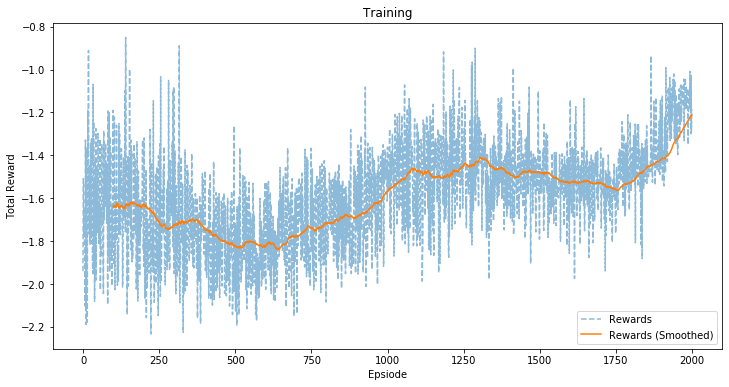

In [9]:
episodes = 2000
epsilon_decay = 0.999985
window_size = 100

env = virl.Epidemic(stochastic=False, noisy=False)
agent = Agent(env, learning_rate=0.002)
memory = ReplayMemory(size=2080, batch_size=208)  # only actually gets the best 104 samples from 208

strategy = Strategy(epsilon=1, epsilon_decay=epsilon_decay)
policy_network, target_network = init_networks(agent.get_num_states(), agent.get_num_actions(), agent.learning_rate)

rewards = qlearning_nn(
    agent=agent, 
    policy_network=policy_network, 
    target_network=target_network,
    num_episodes=episodes,
    window_size=window_size, 
    strategy=strategy,
    memory=memory
)

# Evaluation

In [ ]:
for i in range(10):
    agent = Agent(virl.Epidemic(stochastic=False, noisy=False, problem_id=i), learning_rate=0.0)
    rewards = qlearning_nn(
        agent=agent,
        policy_network=policy_network,
        target_network=target_network,
        num_episodes=1,
        window_size=5
    )

Evaluation reward -1.1202259552436684
Evaluation reward -0.6291999801501303
Evaluation reward -0.6293770338129265
Evaluation reward -0.6317200225475976
Evaluation reward -0.8339073413311735
Evaluation reward -1.3736842484821354
Evaluation reward -1.4762081631864574
Evaluation reward -1.5914215674287149
Evaluation reward -1.7230022254511363


In [11]:
def epsilon_with(decay, episodes):
    print("Epsilon with decay " + str(decay) + " and " + str(episodes) + " episodes")
    check_epsilon_after(decay, int(episodes/4))    
    check_epsilon_after(decay, int(episodes/2))    
    check_epsilon_after(decay, int((episodes*3)/4))    
    check_epsilon_after(decay, int(episodes))
    print("------")

def check_epsilon_after(decay, episodes):
    value = (decay**52)**episodes
    print("After " + str(episodes) + " episodes, epsilon will be " + str(value))
    
# epsilon_with(0.99989, 300)
# epsilon_with(0.999986, 3000)
# epsilon_with(0.999985, 2000)

In [12]:
policy_network.model.save_weights("policy_network.h5")